# **Image Classifier**

## Project Content <a id = 0></a>

### First Step: First Organization

1. [Introduction](#1)
2. [Loading libraries and packages to embark our new journey](#2)
3. [Checking The Dataset](#3)
4. [Creating a Data Pypeline and Loading The Dataset](#4)

### Second Step: Data Preprocessing

5. [Scaling The Data](#5)
6. [Seperating Data into Three Parts of Train, Validation and Test Sets](#6)
7. [Categorical Fields Analysis](#7)
8. [Feature Scaling](#8)
9. [Seperating Data into Two Parts of Train and Test](#9)

### Third and Final Step: Modeling

7. [Defining Modeling Functions](#7)
8. [Building The Model's Architecture](#8)
9. [First Time Training](#9)
10. [Plotting The Model's Loss and Accuracy](#10)
11. [Model's Performance Evaluation](#11)
12. [Testing The Model](#12)

***

# First Step: First Organization

***

## 1. Introduction <a id = 1></a>

This analysis is focused on the behavior of telecom customers who are more likely to terminate their contracts.

**Fields**
- Demographic information about customers | **Gender, Seniorcitizen, Partnere, Dependents**
- Main services that each customer has signed up for | **Phoneservice, Multiplelines, Internetservice**
- Internet-based services which customers have signed up for | **Onlinesecurity, Onlinebackup, Deviceprotection, Techsupport, and Streamingtv and streamingmovies**
- Customers' accounts information | **Tenure, Monthlycharges, Totalcharges**
- Customers' financial information | **Contract, Paymentmethod, Paperlessbilling**
- Customers who left within the last month | **Churn**

[Project Content](#0)

## 2. Loading libraries and packages to embark our new journey <a id = 2></a>

In [1]:
# Basic Python Packages
import os
import uuid
import time
import random

# Numpy Library
import numpy as np

# Pandas Library and Settings
import pandas as pd

# Visualization Libraries (Matplotlib, Seaborn)
import matplotlib.pyplot as plt

# Tensorflow Library
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision
    
# OpenCV
import cv2
import imghdr

# Albumentations
import albumentations as alb

# JSON
import json

%matplotlib inline

[Project Content](#0)

## <font color="red">3. Collecting Images</font> <a id = 3></a>

In [2]:
images_path = os.path.join("data", "images")

# Images number
m = 90

In [ ]:
# Establish a conncetion with device camera.
capture = cv2.VideoCapture(0)

# Capture the images
for image_num in range(m):
    
    print(f"Collecting the image {image_num}")
    
    ret, frame = capture.read()
    
    image_path = os.path.join(images_path, f"{str(uuid.uuid1())}.jpeg")
    
    cv2.imwrite(image_path, frame)
    cv2.imshow("frame", frame)
    
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
    
capture.release()
cv2.destroyAllWindows()

print("Process finished!")

[Project Content](#0)

## 4. Labeling Images <a id = 4></a>

This step will be done using Labelme software.

## 5. Reviewing Dataset and Building an Image Loading Function <a id = 5></a>

We have to limit the GPU memory growth by tf, since it will use all of the space of VRAM.

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")

print("List of GPUS")
print("-"*70)

for gpu in gpus:
    print(f"{gpus.index(gpu)}: {gpu}")

print("\nEnabling Dynamic Allocation of GPU Memory")
print("-"*70)

for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    print(f"{gpus.index(gpu)}: Dynamic allocation has been enabled.")

List of GPUS
----------------------------------------------------------------------
0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Enabling Dynamic Allocation of GPU Memory
----------------------------------------------------------------------
0: Dynamic allocation has been enabled.


Now it's time to load images into the tensorflow data pypeline.

In [4]:
images = tf.data.Dataset.list_files("data/images/*.jpeg", shuffle=False)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpeg'

Now, everyhing is fine and we can load and check the images.

In [ ]:
def load_image(image_path):
    """
    Reads an image file from the given file path and decodes it into a TensorFlow tensor.

    Args:
        image_path (str): The file path of the image to be loaded.

    Returns:
        decoded_image (tensor): A TensorFlow tensor representing the image.
    """
    
    byte_image = tf.io.read_file(image_path)
    decoded_image = tf.io.decode_jpeg(byte_image)
    
    return decoded_image

Map function will run load image function on each object of the dataset which are passed to pypeline.

In [ ]:
images = images.map(load_image)

NameError: name 'images' is not defined

And the last step before viewing the images is to batching them for model's input.

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
i = 0

for batch in image_generator:
    
    print(f"Batch {i + 1}: {batch.shape}")
    i += 1

Now we can visualize these images.

* Remember to assign the variable again in order to make the itteration alive.

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
fig, axes = plt.subplots(ncols=4, figsize=(30, 20))

for index, image in enumerate(image_generator.next()):
    axes[index].imshow(image)

[Project Content](#0)

***

# Second Step: Data Preprocessing

***

## <font color="red">6. Partitioning Unaugmented Data into Three Parts of Train, Validation and Test Sets</font> <a id = 6></a>

First thing first, we have to move the images.

In [8]:
images_destination_directories = ["data/train/images",
                                  "data/validation/images",
                                  "data/test/images"]

proportions = [0.75, 0.15, 0.10]

images_list = os.listdir(images_path)

random.shuffle(images_list)

num_files = len(images_list)
num_destination_files = [int(num_files * proportion) for proportion in proportions]
num_destination_files[-2] += num_files - sum(num_destination_files)

start_index = 0

for directory_index, directory in enumerate(images_destination_directories):
    
    end_index = start_index + num_destination_files[directory_index]
    
    images_to_move = images_list[start_index:end_index]
        
    for image in images_to_move:
            
        source_path = os.path.join(images_path, image)
        destination_path = os.path.join(directory, image)
        
        os.rename(source_path, destination_path)
    
    start_index = end_index

print("Image files moved successfully!")

Image files moved successfully!


Now, we can move the labels based on the images.

In [9]:
labels_path = os.path.join("data", "labels")

labels_destination_directories = ["data/train/labels",
                                  "data/validation/labels",
                                  "data/test/labels"]

for directory_index, directory in enumerate(images_destination_directories):
        
    images_list = os.listdir(directory)
    
    for image in images_list:
                
        label_to_move = image.split(".")[0] + ".json"
        source_path = os.path.join(labels_path, label_to_move)      
        
        if os.path.exists(source_path):
        
            destination_path = os.path.join(labels_destination_directories[directory_index], label_to_move)

            os.rename(source_path, destination_path)
        
print("Label files moved successfully!")

Label files moved successfully!


## <font color="orange">7. Applying Image Augmentation on Images and Labels</font> <a id = 7></a>

Now, we want to augement the images in each type of train, validation and test.</br>
Firstly, we have to create an augmentation pypeline.

In [10]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                         bbox_params=alb.BboxParams(format="albumentations",
                                                    label_fields=["class_labels"]))

Let's check this pypeline for an image and its annonation.

In [24]:
image = cv2.imread(os.path.join(images_destination_directories[0], "5b83db12-f3a0-11ed-86cc-5e8f2d19bd87.jpeg"))

print(f"Image shape is")
print("-"*50)
print(f"{image.shape}\n")
print(f"Image")
print("-"*50)
print(image)

Image shape is
--------------------------------------------------
(720, 1280, 3)

Image
--------------------------------------------------
[[[ 95  95  59]
  [ 89  89  53]
  [ 77  78  46]
  ...
  [168 164 129]
  [167 162 129]
  [165 160 127]]

 [[ 94  94  58]
  [ 91  91  55]
  [ 72  73  41]
  ...
  [167 163 128]
  [166 161 128]
  [165 160 127]]

 [[ 88  88  52]
  [ 87  87  51]
  [ 72  73  41]
  ...
  [167 163 128]
  [166 161 128]
  [166 161 128]]

 ...

 [[188 217 231]
  [187 216 230]
  [190 219 233]
  ...
  [131 178 222]
  [131 178 222]
  [132 179 223]]

 [[187 216 230]
  [186 215 229]
  [190 219 233]
  ...
  [129 175 222]
  [128 177 223]
  [130 179 225]]

 [[186 215 229]
  [185 214 228]
  [189 218 232]
  ...
  [127 173 220]
  [127 176 222]
  [128 177 223]]]


In [29]:
with open(os.path.join(labels_destination_directories[0], "5b83db12-f3a0-11ed-86cc-5e8f2d19bd87.json"), "r") as label_file:
    label = json.load(label_file)
    
print("Image's label details")
print("-"*50)
for key in label.keys():
    print(f"{key}: {label[key]}")
    
print("\nImage's label points")
print("-"*50)
print(label["shapes"][0]["points"])

Image's label details
--------------------------------------------------
version: 4.5.12
flags: {}
shapes: [{'label': 'face', 'points': [[676.8387096774194, 22.290322580645167], [924.4193548387096, 370.6774193548387]], 'group_id': None, 'shape_type': 'rectangle', 'flags': {}}]
imagePath: 5b83db12-f3a0-11ed-86cc-5e8f2d19bd87.jpeg
imageData: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCALQBQADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGR

The thing we want to extract from the labels is the vector of the points, so let's do that.

In [30]:
coordinates = [0, 0, 0, 0]
# x1, y1, x2, y2

coordinates[0] = label["shapes"][0]["points"][0][0]
coordinates[1] = label["shapes"][0]["points"][0][1]
coordinates[2] = label["shapes"][0]["points"][1][0]
coordinates[3] = label["shapes"][0]["points"][1][1]

coordinates

[676.8387096774194, 22.290322580645167, 924.4193548387096, 370.6774193548387]

As we want to use normalized albumanisation, we have to divide the image's annonation x and y by the width and height of the image.</br>
Meaning that we have to rescale it to match the image resolution.

In [31]:
image_height, image_width, _ = image.shape

coordinates[0] /= image_width
coordinates[1] /= image_height
coordinates[2] /= image_width
coordinates[3] /= image_height

coordinates

[0.5287802419354839,
 0.030958781362007175,
 0.7222026209677419,
 0.5148297491039426]

Now, we can apply the augmentation and check the results.

In [15]:
augmented_image = augmentor(image=image, bboxes=[coordinates], class_labels=["face"])

print("Augmented image has these keys")
print("-"*50)
for key in augmented_image.keys():
    print(f"\n* {key}")
    print(f"\n{augmented_image[key]}")

Augmented image has these keys
--------------------------------------------------

* image

[[[ 72  56   4]
  [ 82  66  14]
  [ 81  65  13]
  ...
  [ 29  53  37]
  [ 33  57  41]
  [ 29  49  34]]

 [[ 73  57   5]
  [ 81  65  13]
  [ 80  64  12]
  ...
  [ 29  53  37]
  [ 27  51  33]
  [ 17  38  20]]

 [[ 86  70  18]
  [ 79  63  11]
  [ 86  70  18]
  ...
  [ 25  49  33]
  [ 22  44  26]
  [ 14  35  17]]

 ...

 [[103 150 166]
  [103 150 166]
  [103 150 166]
  ...
  [163 181 152]
  [161 181 152]
  [160 180 151]]

 [[104 151 167]
  [103 150 166]
  [102 149 165]
  ...
  [165 183 154]
  [163 183 154]
  [162 182 153]]

 [[104 151 167]
  [103 150 166]
  [101 148 164]
  ...
  [163 183 154]
  [162 182 153]
  [161 181 152]]]

* bboxes

[(0.0, 0.6762724014336917, 0.17591397849462354, 1.0)]

* class_labels

['face']


Let's check the augmented image and its original format.

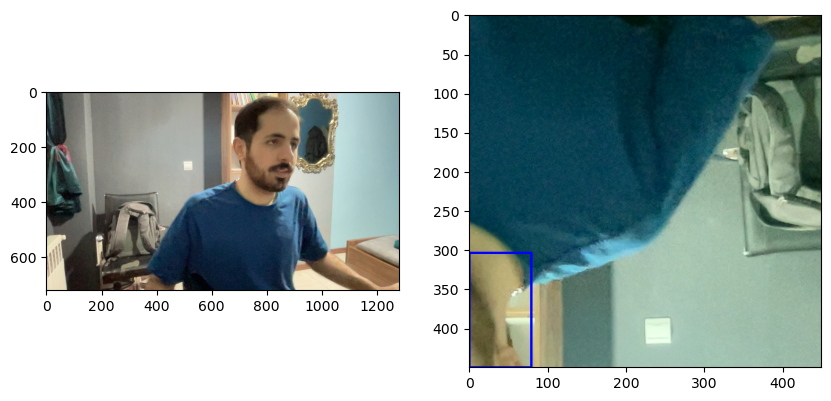

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

cv2.rectangle(augmented_image["image"],
              tuple(np.multiply(augmented_image["bboxes"][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented_image["bboxes"][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)

axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(augmented_image["image"], cv2.COLOR_BGR2RGB))

Now, everything is ok and we can build and run the augmentation pypeline.

In [33]:
for partition in ["train", "test", "validation"]: 
    for image in os.listdir(os.path.join("data", partition, "images")):
        img = cv2.imread(os.path.join("data", partition, "images", image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join("data", partition, "labels", f"{image.split('.')[0]}.json")
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label = json.load(f)

            coords[0] = label["shapes"][0]["points"][0][0]
            coords[1] = label["shapes"][0]["points"][0][1]
            coords[2] = label["shapes"][0]["points"][1][0]
            coords[3] = label["shapes"][0]["points"][1][1]
            
            img_height, img_width, _ = img.shape

            coords[0] /= image_width
            coords[1] /= image_height
            coords[2] /= image_width
            coords[3] /= image_height

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])
                cv2.imwrite(os.path.join("aug_data", partition, "images", f"{image.split('.')[0]}.{x}.jpg"), augmented["image"])

                annotation = {}
                annotation["image"] = image

                if os.path.exists(label_path):
                    if len(augmented["bboxes"]) == 0: 
                        annotation["bbox"] = [0, 0, 0, 0]
                        annotation["class"] = 0 
                    else: 
                        annotation["bbox"] = augmented["bboxes"][0]
                        annotation["class"] = 1
                else: 
                    annotation["bbox"] = [0, 0, 0, 0]
                    annotation["class"] = 0 


                with open(os.path.join("aug_data", partition, "labels", f"{image.split('.')[0]}.{x}.json"), "w") as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.6636088709677419, 0.08920250896057347, 0.4727066532258065, 0.5517921146953405, 'face'].
x_max is less than or equal to x_min for bbox [0.6667590725806452, 0.07352150537634408, 0.4859375, 0.49578853046594984, 'face'].
y_max is less than or equal to y_min for bbox [0.5060987903225806, 0.5909946236559139, 0.91484375, 0.0, 'face'].
y_max is less than or equal to y_min for bbox [0.4349042338709677, 0.36698028673835126, 0.6610887096774194, 0.15752688172043008, 'face'].
y_max is less than or equal to y_min for bbox [0.0014364919354838712, 0.548431899641577, 0.1734375, 0.0, 'face'].
x_max is less than or equal to x_min for bbox [0.6182459677419355, 0.14296594982078853, 0.514289314516129, 0.5170698924731183, 'face'].
x_max is less than or equal to x_min for bbox [0.6056451612903226, 0.48458781362007175, 0.4588457661290323, 0.16312724014336916, 'face'].
image must be numpy array type
x_max is less than or equal to x_min for bbox [0.656048387096774

***

# Third and Final Step: Modeling

***

## 7. Defining Modeling Functions <a id = 7></a>

## 8. Building The Model's Architecture <a id = 8></a>

## 9. First Time Training <a id = 9></a>

## 10. Plotting The Models's Loss and Accuracy <a id = 10></a>

## 11. Model's Performance Evaluation <a id = 12></a>

## 12. Testing The Model <a id = 12></a>